## Analyzing the Drivers of Corporate Financial Resilience

by Shyam Sankar (Operation Resilience)

Economic shocks have become more frequent and unpredictable, making financial resilience a key competitive advantage for modern businesses. While companies across industries operate under the same macroeconomic conditions, their ability to withstand disruptions varies widely—some remain stable, while others falter under pressure.

To understand why a two-stage analytical approach:

1. **Macro-Level Analysis**:
We first examine broad economic conditions from 2009 to 2023, a period shaped by the post-GFC recovery, commodity shocks, the COVID-19 crisis, and the inflation-driven rate surge. By analyzing indicators such as GDP, CPI, unemployment, interest rates, and financial stress, we build a clear picture of how each economic chapter impacted business environments.

2. **Industry Deep Dive**:
Next, we focus on three contrasting industries—Crop Production, Software, and Real Estate. Using sector-level financial ratios (liquidity, leverage, efficiency, and profitability), we evaluate how each industry performed across the same economic cycles. This helps us uncover who remained resilient and why.

By combining macro trends with industry-specific financial behavior, the project aims to reveal the patterns and decisions that allow certain sectors to thrive even in turbulent times.

**Economic Chapters (2009–2023)**

1. Post–Financial Crisis Recovery (2009–2012)

A slow rebuilding phase where companies focused on restoring liquidity, controlling leverage, and stabilizing operations after the 2008 collapse.

2. Mid-Decade Expansion & Commodity Shocks (2013–2016)

Growth resumed, but sharp swings in global oil and commodity prices created volatility that affected capital-intensive and resource-dependent industries.

3. Late-Decade Stability (2017–2019)

A period of steady economic conditions with predictable interest rates, low unemployment, and broadly strong corporate performance.

4. COVID-19 Shock & Aftermath (2020–2021)

An abrupt global shutdown triggered massive economic stress, followed by an unusually rapid recovery driven by monetary and fiscal stimulus.

5. Inflation & Rising Rates (2022–2023)

Surging inflation and aggressive Federal Reserve rate hikes introduced renewed financial pressure, tightening liquidity and weakening margins across many sectors.

### Stage 1: Macro-level Analysis

At the macro level, we use FRED economic indicators—GDP growth, inflation, unemployment, interest rates, and financial stress—to map how major economic conditions evolved across each period and how they shaped the financial environment businesses operated in.

Data Source: Federal Reserve Economic Data(FRED)

In [8]:
!pip install fredapi

In [11]:
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt
fred = Fred(api_key="4e7e0b6d9cd9becadd577e152b07fe7e")

In [13]:
series = {
    "GDP": "GDPC1",
    "CPI": "CPIAUCSL",
    "Unemployment": "UNRATE",
    "FedFunds": "FEDFUNDS",
    "FinancialStress": "STLFSI2",
    "CorporateBBB": "BAMLC0A4CBBB"
}
macro = pd.DataFrame({
    name: fred.get_series(code) for name, code in series.items()
})
# Convert index to datetime
macro.index = pd.to_datetime(macro.index)
# Resample to monthly (end of month) and forward-fill
macro = macro.resample("M").last().ffill()
# Filter date range
macro = macro.loc["2000-01-01":"2023-12-31"]

/var/folders/yp/0g_p5lwd62j955c_8v5nw4rc0000gn/T/ipykernel_54597/1911513657.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  macro = macro.resample("M").last().ffill()


In [15]:
series = {
    "GDP": "GDPC1",                 # Real GDP (quarterly)
    "CPI": "CPIAUCSL",              # CPI (monthly)
    "Unemployment": "UNRATE",       # Unemployment rate (monthly)
    "FedFunds": "FEDFUNDS",         # Fed Funds Rate (daily)
    "FinancialStress": "STLFSI2",   # St. Louis Financial Stress Index (weekly)
    "CorporateBBB": "BAMLC0A4CBBB"  # ICE BofA BBB Yield (daily)
}

# Economic chapters used for shading
chapters = {
    "GFC Aftermath": (2009, 2009),
    "Recovery & Expansion": (2010, 2014),
    "Commodity Shocks": (2015, 2016),
    "COVID-19": (2019, 2021),
    "Inflation": (2021, 2022)
}


#FETCH + RESAMPLE TO MONTHLY
macro = pd.DataFrame({
    name: fred.get_series(code) for name, code in series.items()
})

# Convert index to datetime
macro.index = pd.to_datetime(macro.index)

# Resample to monthly (end of month) and forward-fill
macro = macro.resample("M").last().ffill()

# Filter date range
macro = macro.loc["2000-01-01":"2023-12-31"]

# Load recession indicator and resample it too
recessions = fred.get_series("USREC")
recessions.index = pd.to_datetime(recessions.index)
recessions = recessions.resample("M").last().ffill()
recessions = recessions.loc[macro.index.min():macro.index.max()]

# Build datetime ranges for chapter shading
chapter_ranges = {
    name: (pd.to_datetime(f"{start}-01-01"), pd.to_datetime(f"{end}-12-31"))
    for name, (start, end) in chapters.items()
}

macro.head()

/var/folders/yp/0g_p5lwd62j955c_8v5nw4rc0000gn/T/ipykernel_54597/151775079.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  macro = macro.resample("M").last().ffill()
/var/folders/yp/0g_p5lwd62j955c_8v5nw4rc0000gn/T/ipykernel_54597/151775079.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  recessions = recessions.resample("M").last().ffill()


,GDP,CPI,Unemployment,FedFunds,FinancialStress,CorporateBBB
2000-01-31,13878.147,169.3,4.0,5.45,0.0643,1.56
2000-02-29,13878.147,170.0,4.1,5.73,0.2169,1.66
2000-03-31,13878.147,171.0,4.0,5.85,0.2006,1.92
2000-04-30,14130.908,170.9,3.8,6.02,0.3444,2.12
2000-05-31,14130.908,171.2,4.0,6.27,0.7864,2.28


In [17]:
def plot_macro_with_chapters(macro, recessions, column, chapters):
    plt.figure(figsize=(12,5))
    plt.plot(macro.index, macro[column], label=column, linewidth=2)

    # recession shading
    plt.fill_between(
        recessions.index,
        0,
        recessions.values * macro[column].max(),
        color="gray",
        alpha=0.15
    )

    # chapter shading
    colors = ['#ffcccc', '#ccffcc', '#ccccff', '#ffe4cc', '#ccffff']
    chapter_ranges = {
        name: (pd.to_datetime(f"{start}-01-01"), pd.to_datetime(f"{end}-12-31"))
        for name, (start, end) in chapters.items()
    }

    for i, (name, (s, e)) in enumerate(chapter_ranges.items()):
        plt.axvspan(s, e, color=colors[i % len(colors)], alpha=0.25)
        plt.text(
            s + (e - s) / 2,
            macro[column].max() * 0.97,
            name,
            ha='center',
            va='top',
            fontsize=9,
            alpha=0.8
        )

    plt.title(f"{column} (2000–2023) with Economic Chapters")
    plt.xlabel("Date")
    plt.legend()
    plt.tight_layout()
    plt.show()

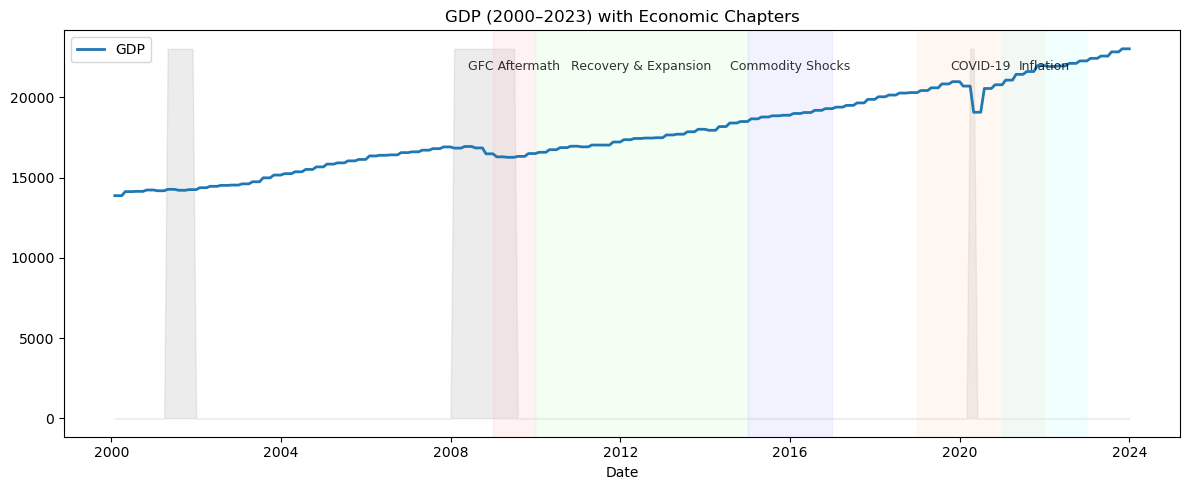

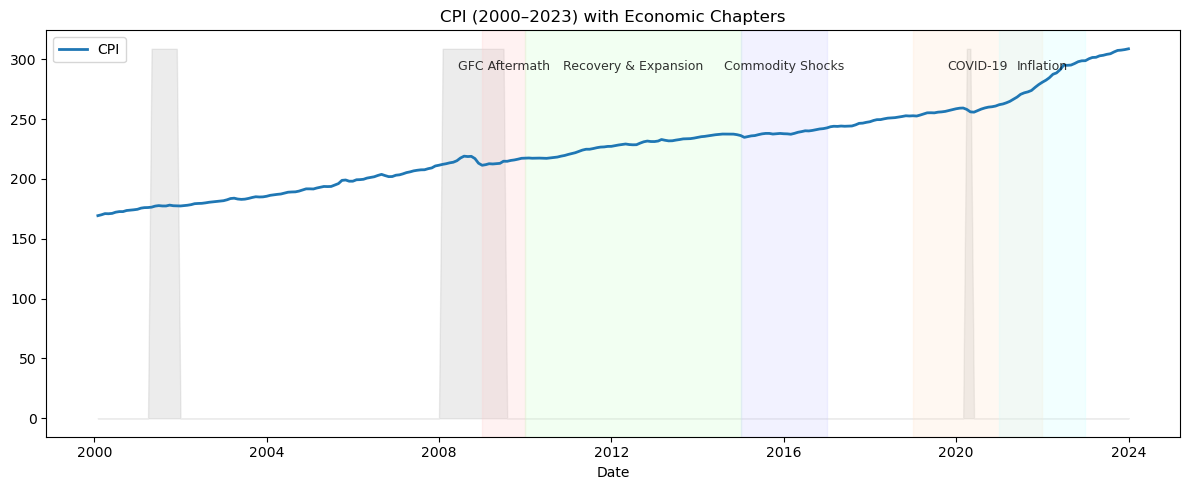

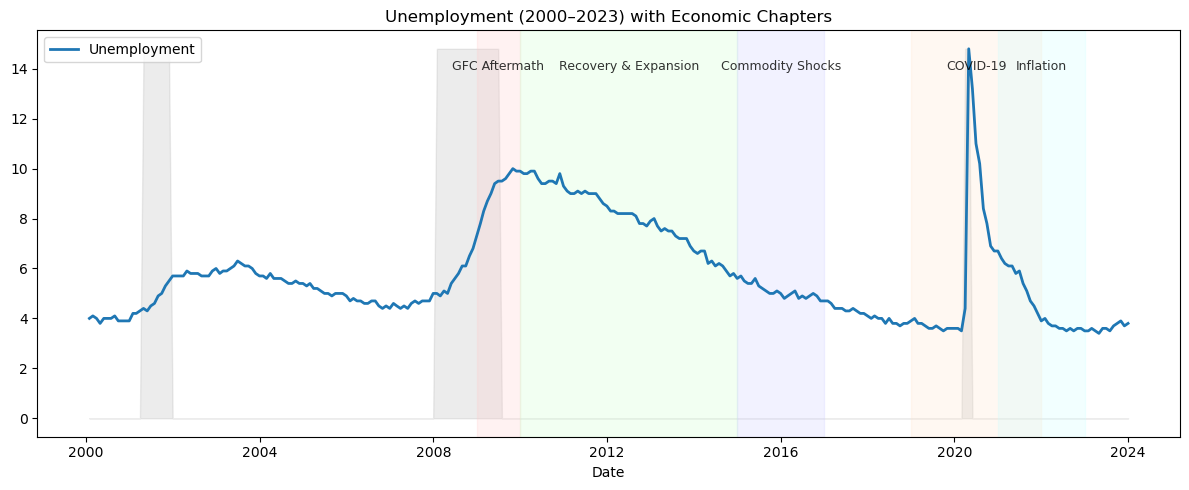

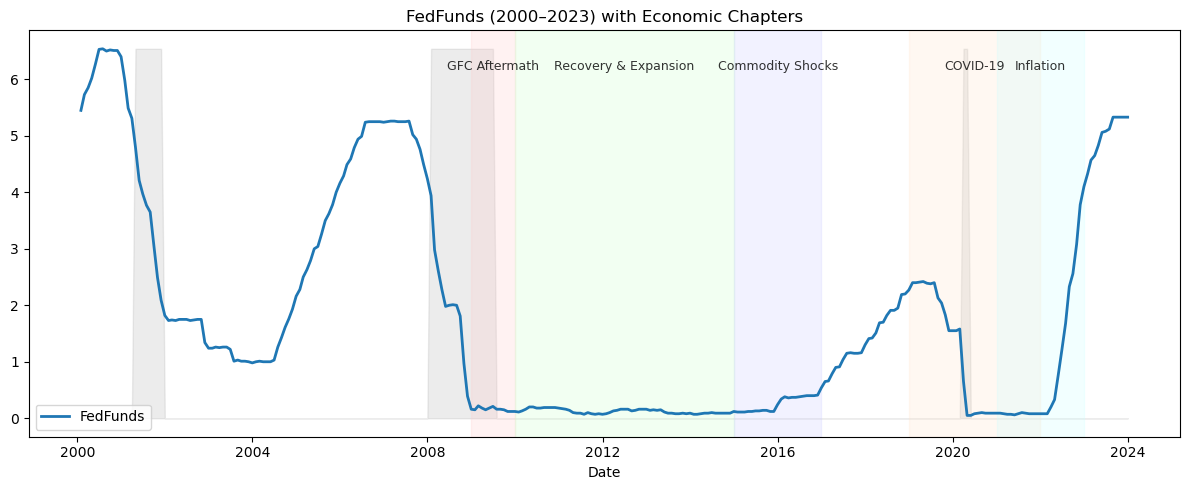

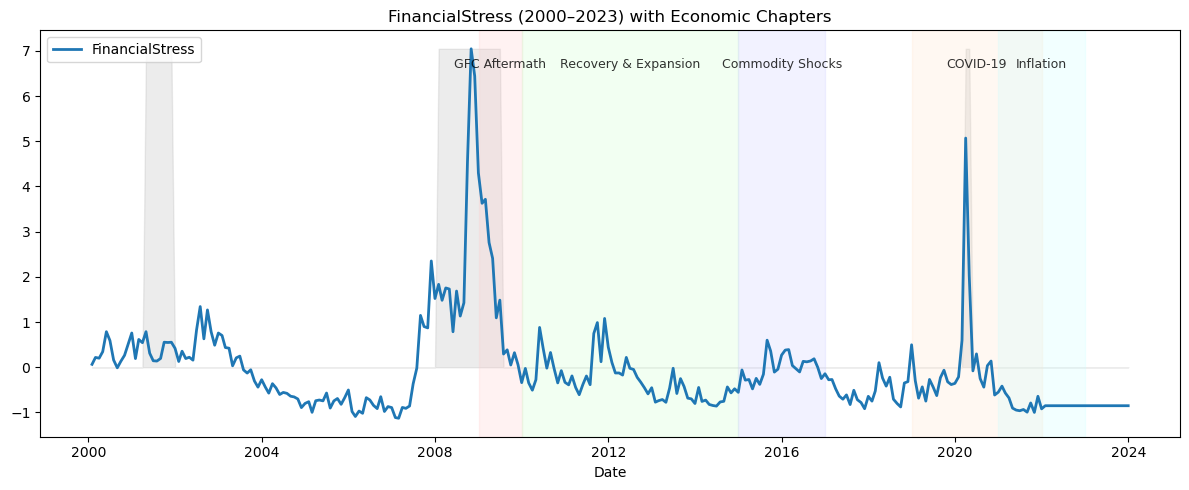

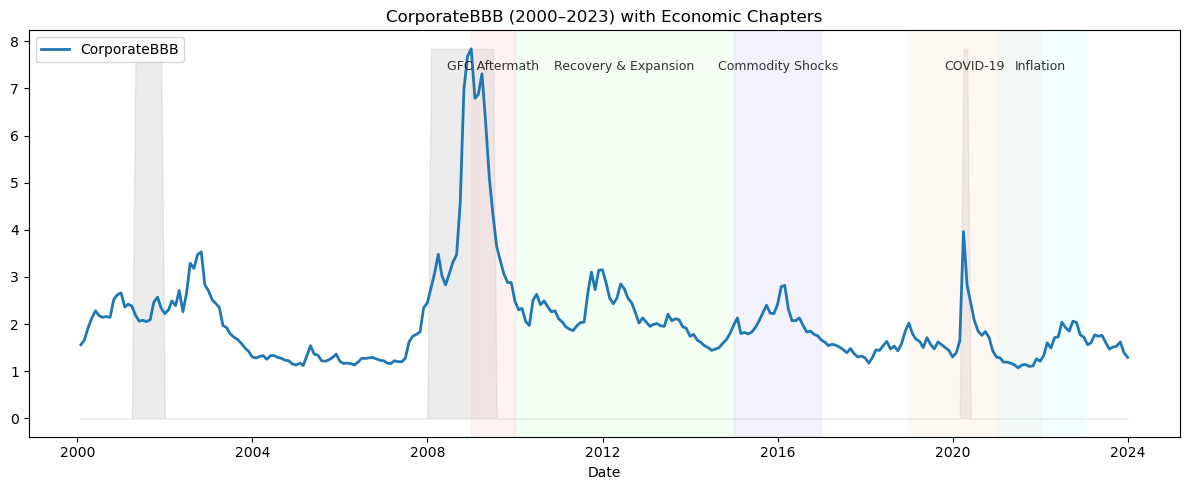

In [25]:
for col in macro.columns:
    plot_macro_with_chapters(macro, recessions, col, chapters)

**Gross Domestic Product (GDP)**: Gross Domestic Product (GDP) measures the total economic output of a country, reflecting overall economic health and growth trends.

Observations:
The graph shows generally steady growth from 2009–2022, with small dips corresponding to the post-financial crisis recovery and the COVID-19 shock, highlighting periods where companies faced heightened external pressures.

**Consumer Price Index (CPI):**: The Consumer Price Index (CPI) tracks changes in the price level of a basket of goods and services, reflecting inflationary pressures in the economy.

Observations: The graph shows generally steady growth, with a considerable rise during the post-COVID inflation period. 

**Financial Stress Index**: The Financial Stress Index measures disruptions and instability in the financial system, capturing market volatility, liquidity shortages, and credit conditions.

Observations: Financial stress peaks during the post-GFC recession and the COVID-19 shock, highlighting periods when companies faced heightened external financial pressures and needed robust resilience strategies.

**Federal Funds Rate**: The Federal Funds Rate is the interest rate at which banks lend to each other overnight, guiding overall borrowing costs in the economy.

Observations: The rate drops sharply after the GFC, stays low through the recovery, rises modestly during commodity shocks, falls again during COVID-19, and then climbs post-pandemic amid inflationary pressures, shaping corporate borrowing and liquidity strategies.

**Corporate BBB Credit Spreads**: BBB credit spreads reflect the extra yield investors demand to hold lower-rated investment-grade corporate debt, indicating perceived credit risk.

Observations: Spreads spike sharply during the post-GFC recession and the COVID-19 shock, mirroring financial stress and signaling periods of higher borrowing costs and risk for corporations.

**Lagged Correlations Between Macroeconomic and Financial Variables**

Computed lagged correlations to examine the delayed effects of key macroeconomic and financial variables. Specifically, we constructed three-period lagged versions of selected indicators, including GDP, Unemployment, and Financial Stress. Each lagged series was then correlated with the contemporaneous values of all variables in the dataset. This approach allowed us to capture how past economic and financial conditions influenced current outcomes, highlighting lead-lag relationships and the persistence of shocks across the macro-financial system.

In [31]:
def lagged_corr(df, lag, cols=None):
    if cols is None:
        cols = df.columns
    
    lagged = df[cols].shift(lag).add_suffix(f'_lag{lag}')
    combined = pd.concat([lagged, df], axis=1)
    
    return combined.corr().loc[lagged.columns, df.columns]
lagged_corr(macro, 3, ['GDP','Unemployment','FinancialStress'])

,GDP,CPI,Unemployment,FedFunds,FinancialStress,CorporateBBB
GDP_lag3,0.994692,0.981649,-0.261068,-0.179663,-0.274425,-0.247787
Unemployment_lag3,-0.216078,-0.134766,0.833920,-0.586740,0.070376,0.240101
FinancialStress_lag3,-0.322403,-0.271162,0.376053,-0.174004,0.668902,0.790806


**GDP**:
Strong positive correlation with current GDP and CPI, meaning economic growth tends to persist across years. Negative correlation with unemployment, financial stress, and BBB spreads, showing that strong past growth generally leads to lower risk today.

**Unemployment**:
Past unemployment strongly predicts current unemployment. It negatively correlates with Fed Funds, showing that high unemployment periods are usually met with lower interest rates. Mild positive relationship with financial stress and credit spreads.

**Financial Stress**:
Past stress levels are highly correlated with current stress and BBB spreads, indicating persistence of financial risk conditions. Moderate positive link with unemployment and negative correlations with GDP and CPI, reflecting that stress lingers during slow-growth environments.

**Year-wise economic score**

Constructed a macroeconomic index by pulling key indicators from FRED, converting them to annual frequency, and normalizing each series to a 0–1 scale. The indicators were then averaged to produce a single Economic Score for each year, capturing overall economic conditions from 2009–2022.

In [35]:
indicators = {
    "GDP Growth (YoY)": "A191RL1Q225SBEA",
    "Unemployment Rate": "UNRATE",
    "Inflation (CPI YoY)": "CPIAUCSL",
    "Federal Funds Rate": "FEDFUNDS",
    "Financial Stress Index": "STLFSI2"
}

df = pd.DataFrame()

for name, code in indicators.items():
    series = fred.get_series(code)
    series.index = pd.to_datetime(series.index)
    yearly = series.resample("A").mean()
    df[name] = yearly

df = df.loc["2009":"2022"]

# CPI must be converted to YoY inflation
df["Inflation (CPI YoY)"] = df["Inflation (CPI YoY)"].pct_change() * 100

#NORMALIZE EACH INDICATOR (0–1)
def normalize_0_1(s):
    return (s - s.min()) / (s.max() - s.min())

normalized = df.copy()
for col in normalized.columns:
    normalized[col] = normalize_0_1(normalized[col])

#ECONOMIC SCORE PER YEAR
normalized["Economic Score"] = normalized.mean(axis=1)

economic_score = normalized["Economic Score"].to_frame()
economic_score.index = economic_score.index.year

print("\n=== ECONOMIC SCORE BY YEAR ===")
print(economic_score)

/var/folders/yp/0g_p5lwd62j955c_8v5nw4rc0000gn/T/ipykernel_54597/1628989516.py:14: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly = series.resample("A").mean()
/var/folders/yp/0g_p5lwd62j955c_8v5nw4rc0000gn/T/ipykernel_54597/1628989516.py:14: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly = series.resample("A").mean()
/var/folders/yp/0g_p5lwd62j955c_8v5nw4rc0000gn/T/ipykernel_54597/1628989516.py:14: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly = series.resample("A").mean()
/var/folders/yp/0g_p5lwd62j955c_8v5nw4rc0000gn/T/ipykernel_54597/1628989516.py:14: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly = series.resample("A").mean()



=== ECONOMIC SCORE BY YEAR ===
      Economic Score
2009        0.496006
2010        0.410594
2011        0.386806
2012        0.312072
2013        0.287806
2014        0.234077
2015        0.195632
2016        0.260429
2017        0.290861
2018        0.345153
2019        0.397662
2020        0.355544
2021        0.375670
2022        0.396255


/var/folders/yp/0g_p5lwd62j955c_8v5nw4rc0000gn/T/ipykernel_54597/1628989516.py:14: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly = series.resample("A").mean()


1. 2009 shows the highest stress-adjusted score among the early years, reflecting the turbulent post-GFC environment where indicators were still heavily distorted.

2. Scores steadily decline from 2010–2015, capturing slow recovery, weak inflation, and lingering unemployment effects.

3. 2016–2019 show gradual improvement, corresponding to stable growth, low interest rates, and reduced financial stress.

4. 2020 dips due to the COVID shock, but the recovery is surprisingly quick thanks to stimulus, leading to stronger scores in 2021–2022.

5. 2022 rebounds further despite high inflation, showing that strong GDP, fast recovery dynamics, and improving labor markets offset macro volatility.

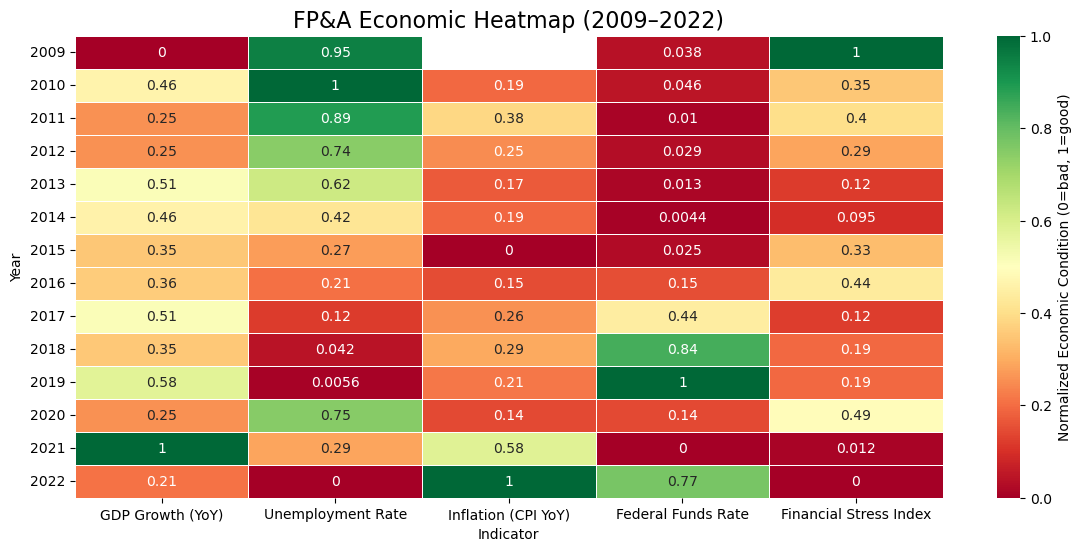

In [38]:
import seaborn as sns
heatmap_df = normalized.copy()
heatmap_df.index = heatmap_df.index.year
heatmap_df = heatmap_df.drop(columns=["Economic Score"])

plt.figure(figsize=(14, 6))
sns.heatmap(
    heatmap_df,
    cmap="RdYlGn",
    linewidths=0.5,
    annot=True,
    cbar_kws={"label": "Normalized Economic Condition (0=bad, 1=good)"}
)
plt.title("FP&A Economic Heatmap (2009–2022)", fontsize=16)
plt.xlabel("Indicator")
plt.ylabel("Year")
plt.show()

### Stage 2: Industry Comparison During Crisis

In Stage 2, we compare three key industries — Real Estate, Software/Computers, and Manufacturing — by analyzing their core financial ratios:
1. Liquidity (short-term strength)
2. Leverage (debt exposure)
3. Profitability (operational efficiency)

By examining how these ratios shifted during the crisis period, we identify which industry showed the strongest financial resilience, which struggled, and why. This ratio-driven comparison helps reveal the structural factors — such as capital intensity, debt levels, cash flow flexibility, and demand stability — that determined how well each sector navigated the downturn.

Data Source: Dun and bradstreet(https://mergentkbr-com.srv-proxy2.library.tamu.edu/). Courtesy of Texas A&M Libraries. Micsrosoft Excel was used to make some changes to the formatting of the excel file(pivoting) to make the csv file ready for Jupyter Notebook. All data files are attached.

In [15]:
import pandas as pd
df_computers = pd.read_csv("computers.csv")
df_crops = pd.read_csv("crops.csv")
df_realestate = pd.read_csv("realestate.csv")

In [46]:
def tidy_industry_df(df, industry_name):
    df['Ratio'] = df['Ratio'].ffill()
    # Melt into long format
    df_long = df.melt(
        id_vars=['Ratio', 'Quartile'],
        var_name='Year',
        value_name='Value'
    )

    # Convert Value to numeric 
    df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')

    # Pivot quartiles into separate columns
    df_tidy = df_long.pivot_table(
        index=['Ratio', 'Year'],
        columns='Quartile',
        values='Value',
        aggfunc='mean'
    ).reset_index()

    # Add industry column
    df_tidy['Industry'] = industry_name

    return df_tidy

In [48]:
df_computers_tidy = tidy_industry_df(df_computers, 'Software')
df_crops_tidy = tidy_industry_df(df_crops, 'Crop Production')
df_realestate_tidy = tidy_industry_df(df_realestate, 'Real Estate')

In [50]:
df_all = pd.concat([df_computers_tidy, df_crops_tidy, df_realestate_tidy], ignore_index=True)

In [52]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12,6)
# Define economic chapters
chapters = {
    "GFC Aftermath": (2009, 2009),
    "Recovery & Expansion": (2010, 2014),
    "Commodity Shocks": (2015, 2016),
    "COVID-19 Pandemic": (2019, 2021),
    "Inflation & Rate Surge": (2021, 2022)
}

In [56]:
liquidity_ratios = ['Quick Ratio', 'Current Ratio']
leverage_ratios = ['Total Liabilities / Net Worth %', 'Current Liabilities / Net Worth %']
efficiency_ratios = ['Collection Period (days)', 'Assets / Sales %', 'Sales / Inventory (times)']
profitability_ratios = ['Return on Sales (Net Profit Margin) %', 'Return on Assets (ROA) %', 'Return on Net Worth (ROE) %']
all_ratios = {
    "Liquidity": liquidity_ratios,
    "Leverage": leverage_ratios,
    "Efficiency": efficiency_ratios,
    "Profitability": profitability_ratios
}

In [58]:
df_all['Year'] = pd.to_numeric(df_all['Year'], errors='coerce')

In [60]:
def plot_ratio_with_chapters(df, ratio_name, category_name, chapters):
    df_ratio = df[df['Ratio'] == ratio_name]
    plt.figure(figsize=(20,6))
    
    # Plot each industry
    for industry in df_ratio['Industry'].unique():
        df_ind = df_ratio[df_ratio['Industry'] == industry]
        plt.plot(df_ind['Year'], df_ind['Median'], label=f"{industry} Median")
        plt.fill_between(df_ind['Year'], df_ind['Lower'], df_ind['Upper'], alpha=0.2)
    
    # Shade economic chapters
    colors = ['#ffdddd','#ddffdd','#ddddff','#fff0dd','#ddffff']
    for i, (chapter, (start, end)) in enumerate(chapters.items()):
        plt.axvspan(start, end, color=colors[i % len(colors)], alpha=0.2)
        plt.text((start+end)/2, plt.ylim()[1]*0.95, chapter, 
                 horizontalalignment='center', fontsize=10, alpha=0.7)
    
    plt.title(f"{category_name} - {ratio_name} Across Economic Chapters")
    plt.xlabel("Year")
    plt.ylabel(ratio_name)
    plt.legend()
    plt.show()

**1. Industry Liquidity Analysis**

To understand how different sectors withstand economic shocks, we begin by examining key liquidity ratios, which indicate a company’s ability to meet short-term obligations. These ratios help reveal how prepared industries like Crop Production, Software, and Real Estate are to handle sudden disruptions in cash flow or economic uncertainty.

**a) Quick Ratio:** Measures how well a firm can cover its short-term liabilities using only its most liquid assets, cash, receivables, and marketable securities.

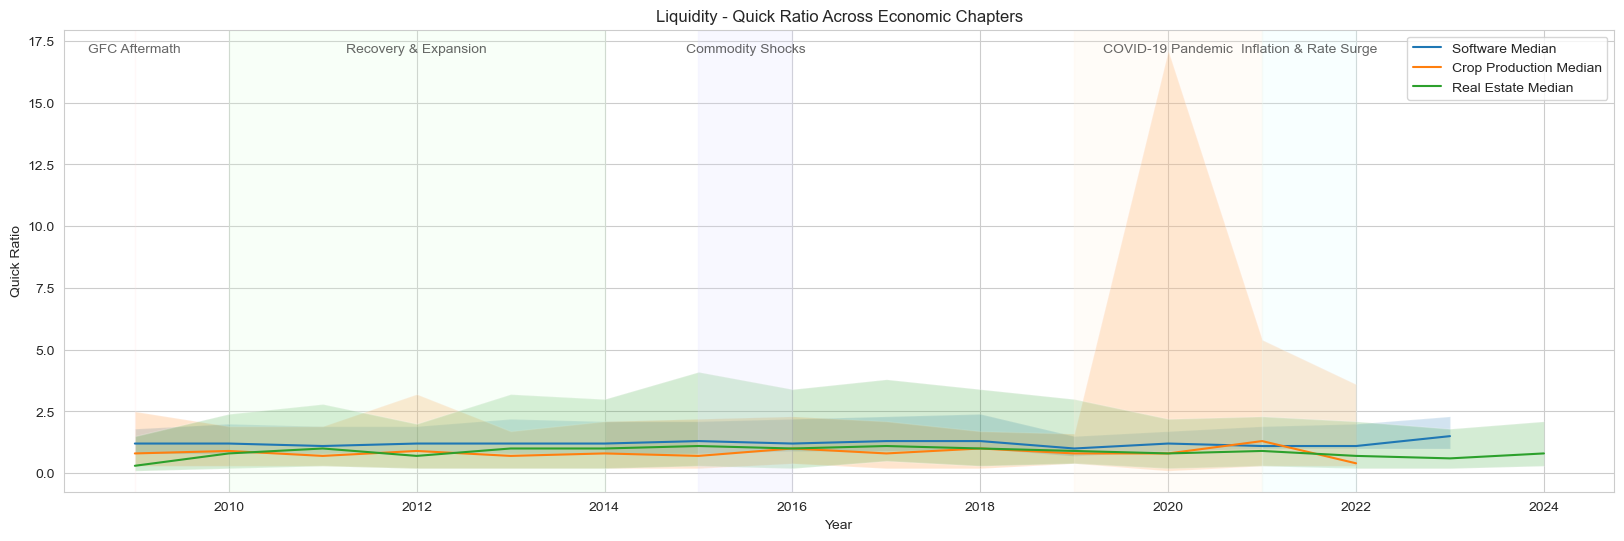

In [62]:
plot_ratio_with_chapters(df_all, 'Quick Ratio', 'Liquidity', chapters)

Over 15 years, Computers/Tech consistently maintained the strongest quick ratio (~1.1–1.25 median), while Real Estate and Crops repeatedly fell into sub-1.0 territory during every major shock.

**b) Current Ratio**:Assesses overall short-term financial health by comparing all current assets to current liabilities.

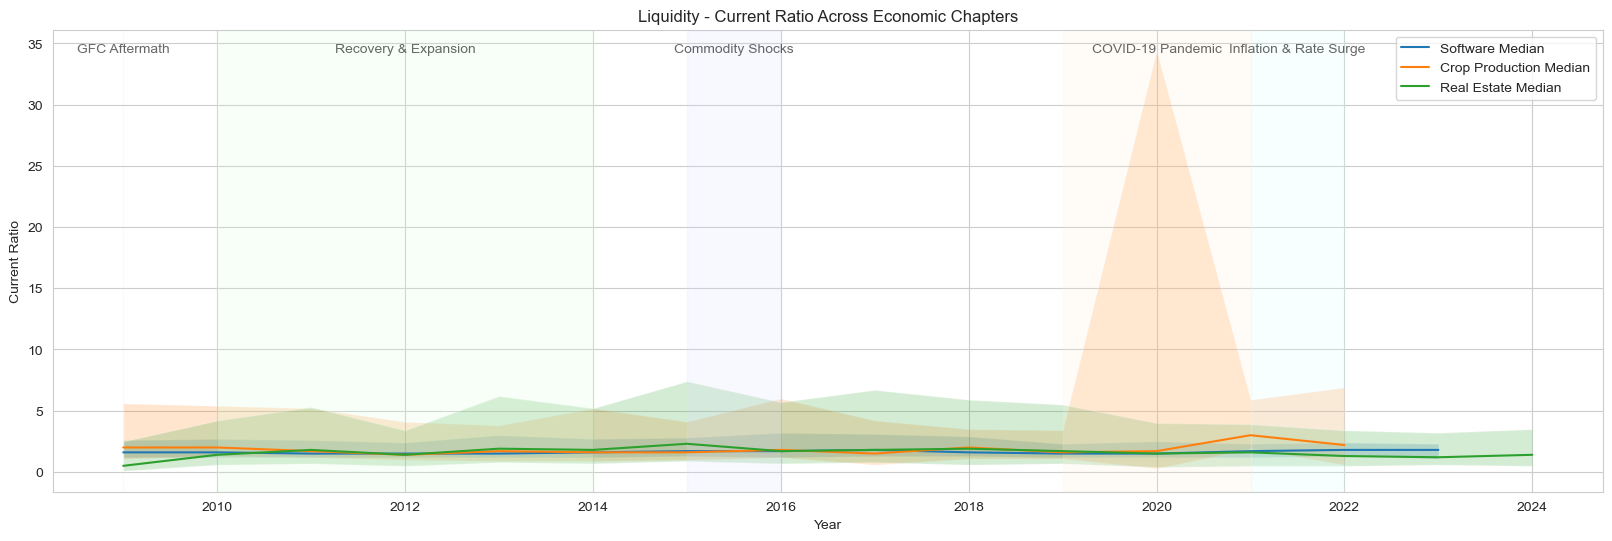

In [68]:
plot_ratio_with_chapters(df_all, 'Current Ratio', 'Liquidity', chapters)

Crops/Agriculture repeatedly showed the strongest current ratio (often >2.0) through every crisis, while Real Estate was the most fragile — collapsing below 1.0 in the GFC and slipping again when rates rose.

**2. Industry Leverage Analysis**

To evaluate the long-term financial stability of each sector, we examine key leverage ratios, which show how heavily an industry relies on debt to finance its operations. These ratios highlight the capital structure pressures faced by Crop Production, Software, and Real Estate, helping us understand which industries are more vulnerable during periods of economic stress.

**a) Total Liabilities / Net Worth (%)**:Indicates overall financial leverage by comparing all liabilities to shareholders’ equity. Higher values suggest increased risk and dependence on borrowed capital.

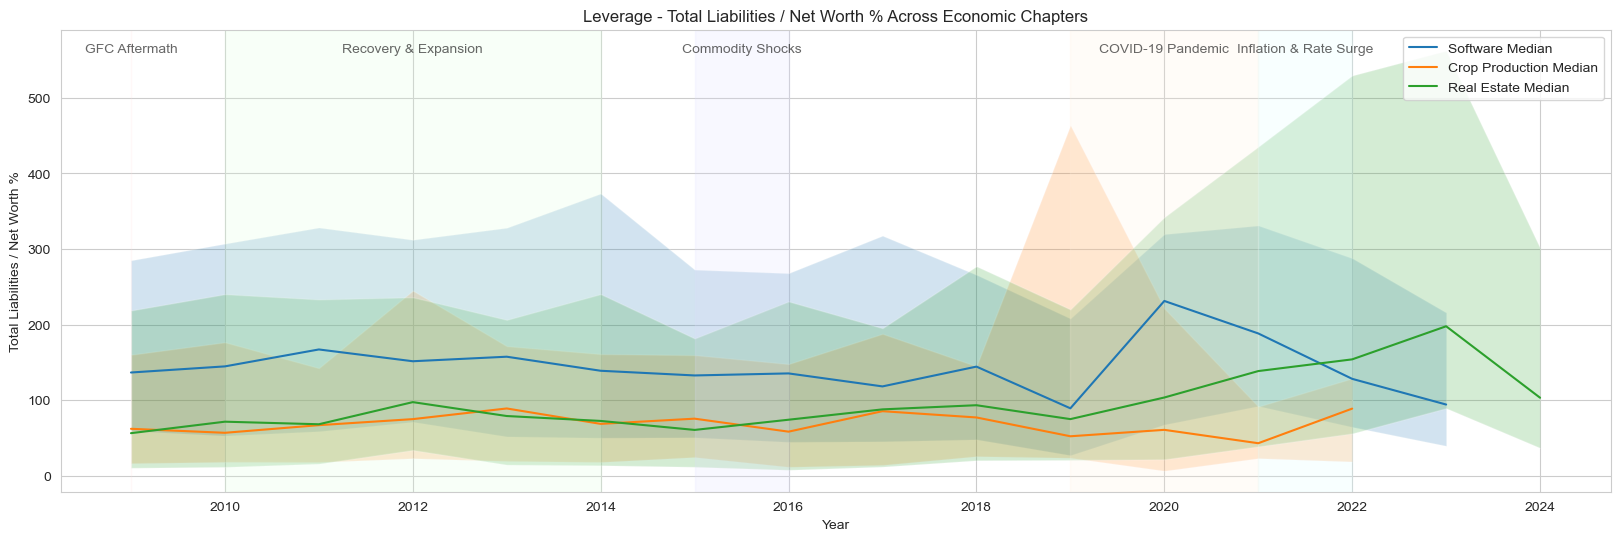

In [73]:
plot_ratio_with_chapters(df_all, 'Total Liabilities / Net Worth %', 'Leverage', chapters)

Real Estate and especially Crops repeatedly piled on debt during every “good times” phase and entered each new crisis with the highest leverage, while Tech/Computers consistently operated with more moderate (though still high) debt-to-equity levels.

**b) Current Liabilities / Net Worth (%)**:  Measures short-term leverage by showing how much of a company’s equity is covered by near-term obligations.

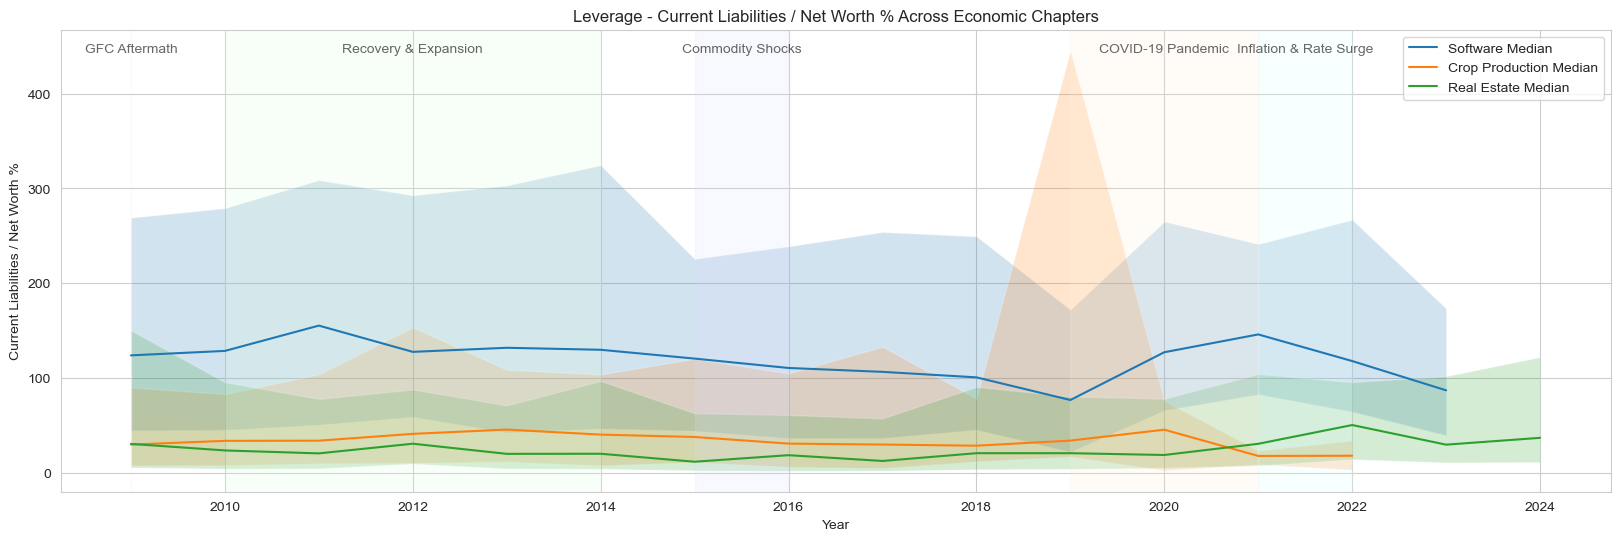

In [76]:
plot_ratio_with_chapters(df_all, 'Current Liabilities / Net Worth %', 'Leverage', chapters)

Crops/Agriculture repeatedly swings from the lowest to the highest short-term leverage in every cycle, Computers live permanently around 130% (structural), and Real Estate opportunistically loads and unloads short-term debt depending on the property cycle.

**3. Efficiency Ratios**

To assess how efficiently each sector runs its operations, we analyze key efficiency ratios that show how well industries convert assets and inventory into revenue. These ratios highlight how operationally efficient Crop Production, Software, and Real Estate are, revealing which industries stay agile during economic stress.

**a) Collection Period (days)**: Indicates how quickly companies collect payments. Lower values show faster cash flow; higher values suggest slower collections and potential liquidity pressure.

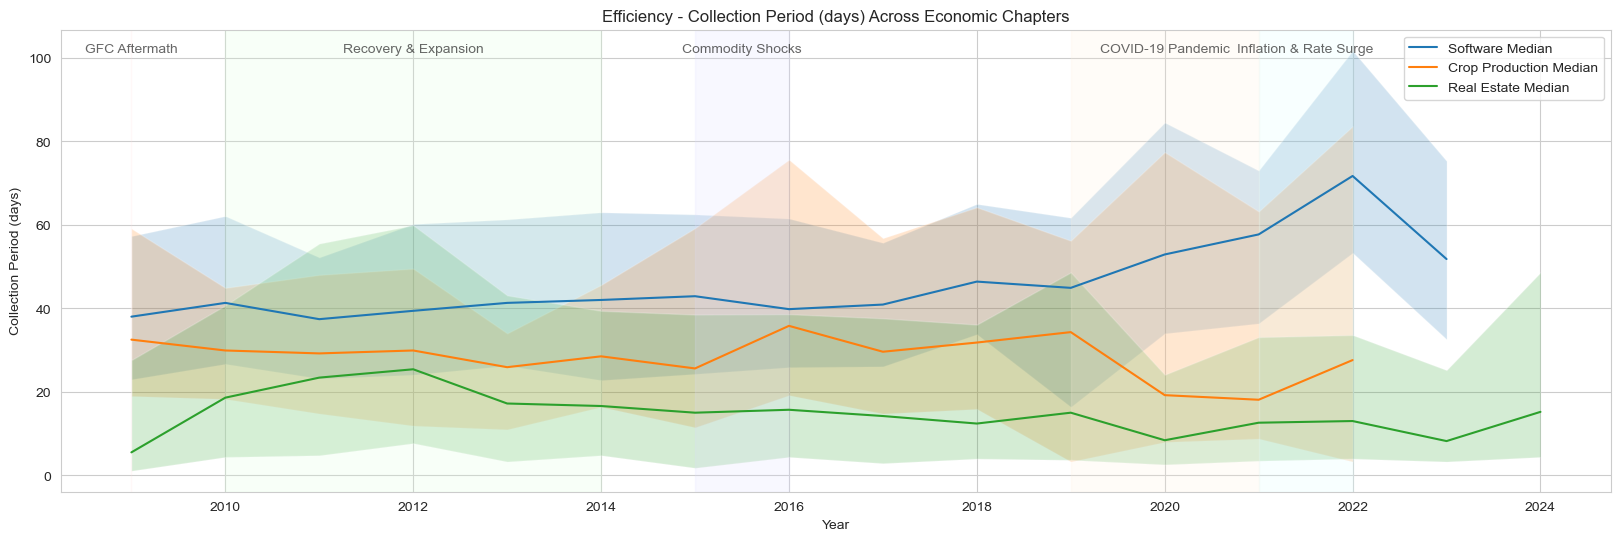

In [82]:
plot_ratio_with_chapters(df_all, 'Collection Period (days)', 'Efficiency', chapters)

Real Estate consistently collects in ~2 weeks or less in every environment, Crops hovers around one month, while Computers/Tech distributors have lived with 40-70 day terms for 15 years and got dramatically worse in every crisis.

**b) Assets / Sales (%)**: Measures asset efficiency. Lower percentages mean assets are being used effectively; higher values point to underutilization

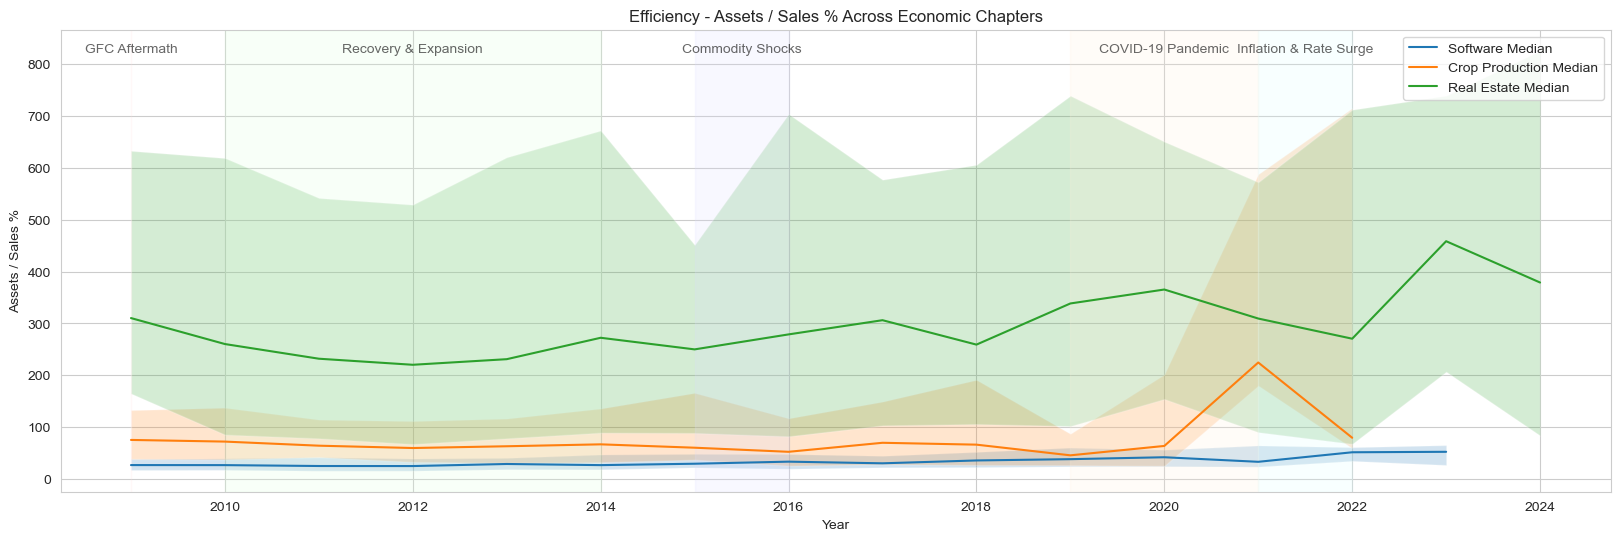

In [86]:
plot_ratio_with_chapters(df_all, 'Assets / Sales %', 'Efficiency', chapters)

Computers/Tech consistently dominated with sub-50% asset-to-sales, while Crops hovered 50-150% and Real Estate chronically >200%—proving asset-light models weather every cycle far better than capital-intensive ones.

**c) Sales / Inventory (times)**: Shows how fast inventory is sold. Higher turnover reflects strong demand and efficient management; lower turnover suggests slower movement or excess stock.

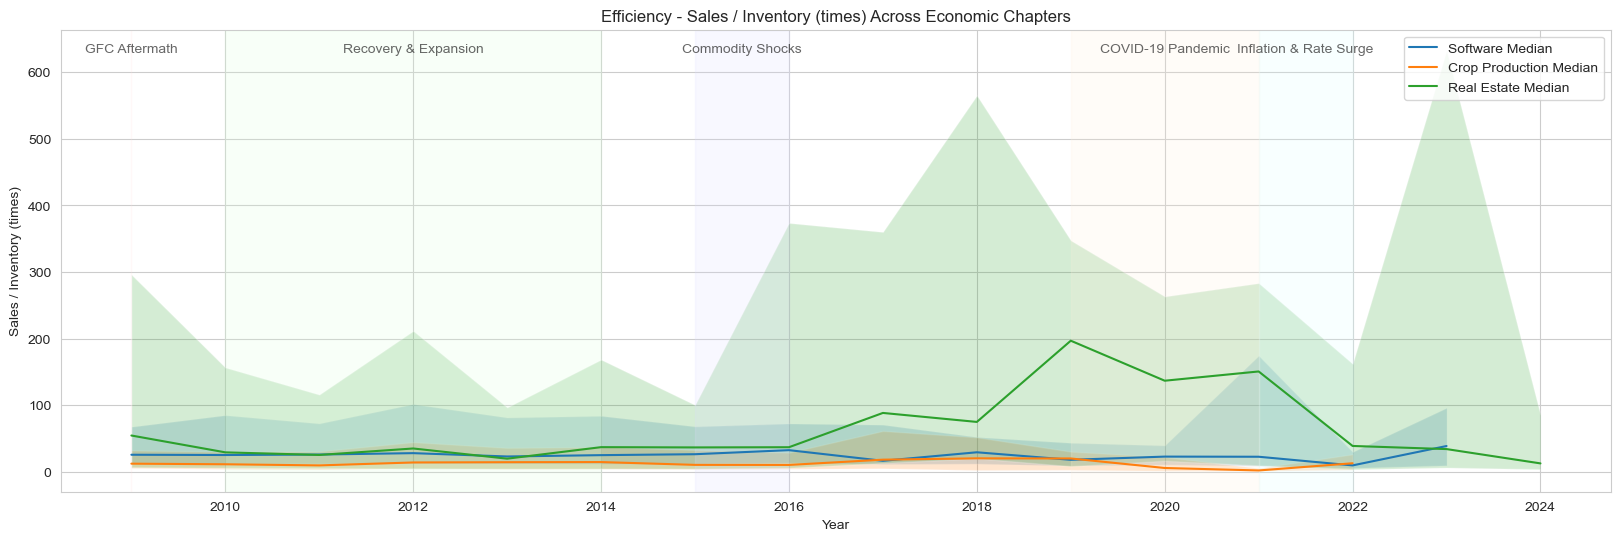

In [90]:
plot_ratio_with_chapters(df_all, 'Sales / Inventory (times)', 'Efficiency', chapters)

Real Estate dominated turnover (often 30-100x) through every cycle, Computers held reliable 18-29x, while Crops chronically lagged (7-14x) — proving low-inventory models like property outpace asset-heavy models in all environments.

**4. Profitability Ratios**

To understand the financial performance of each sector, we examine key profitability ratios that capture how well industries convert revenue and capital into earnings. These ratios reveal which industries deliver stronger financial returns and how profitability shifts during different economic conditions.

**a) Net Profit Margin**: Measures how much profit is kept from each dollar of revenue, indicating overall cost control and pricing power.

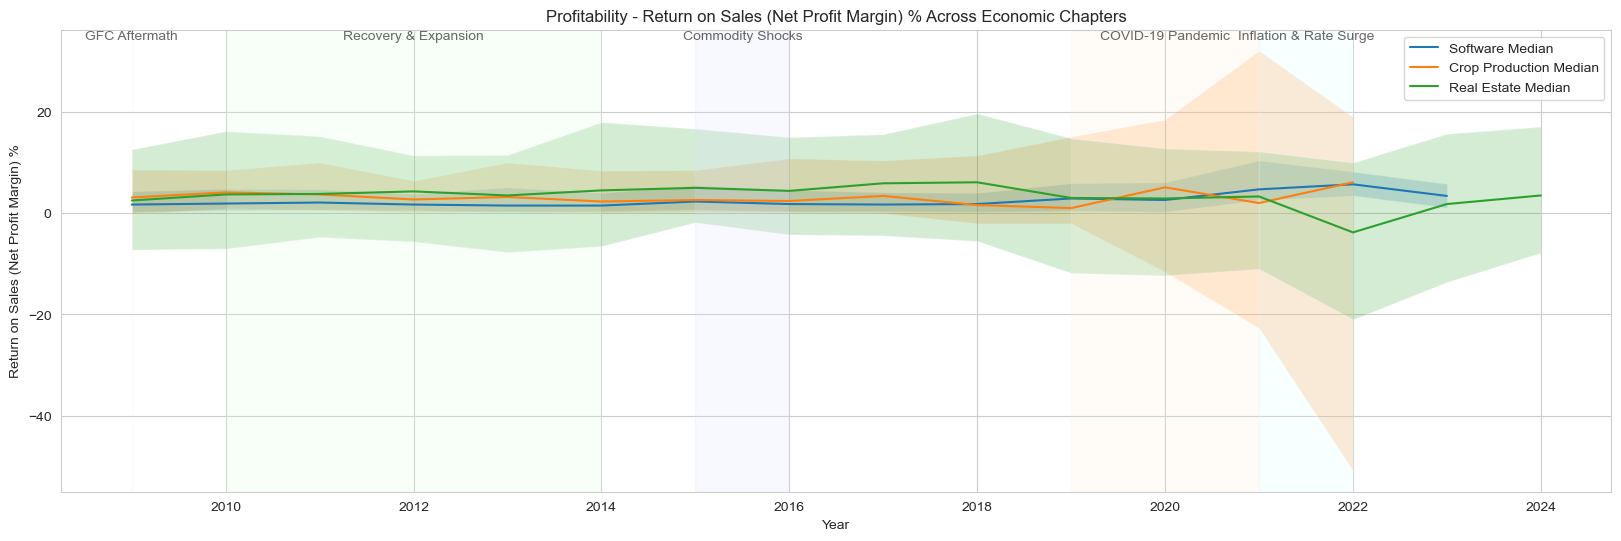

In [95]:
plot_ratio_with_chapters(df_all, 'Return on Sales (Net Profit Margin) %', 'Profitability', chapters)

Over the full cycle, Computers/Tech delivered the most consistent and crisis-resistant margins (always positive, peaking in shocks), Crops were volatile but survived, while Real Estate enjoyed fat margins in good times and got crushed the moment rates rose.

**b) Return on Assets (ROA)**: Shows how efficiently a company uses its asset base to generate profits.

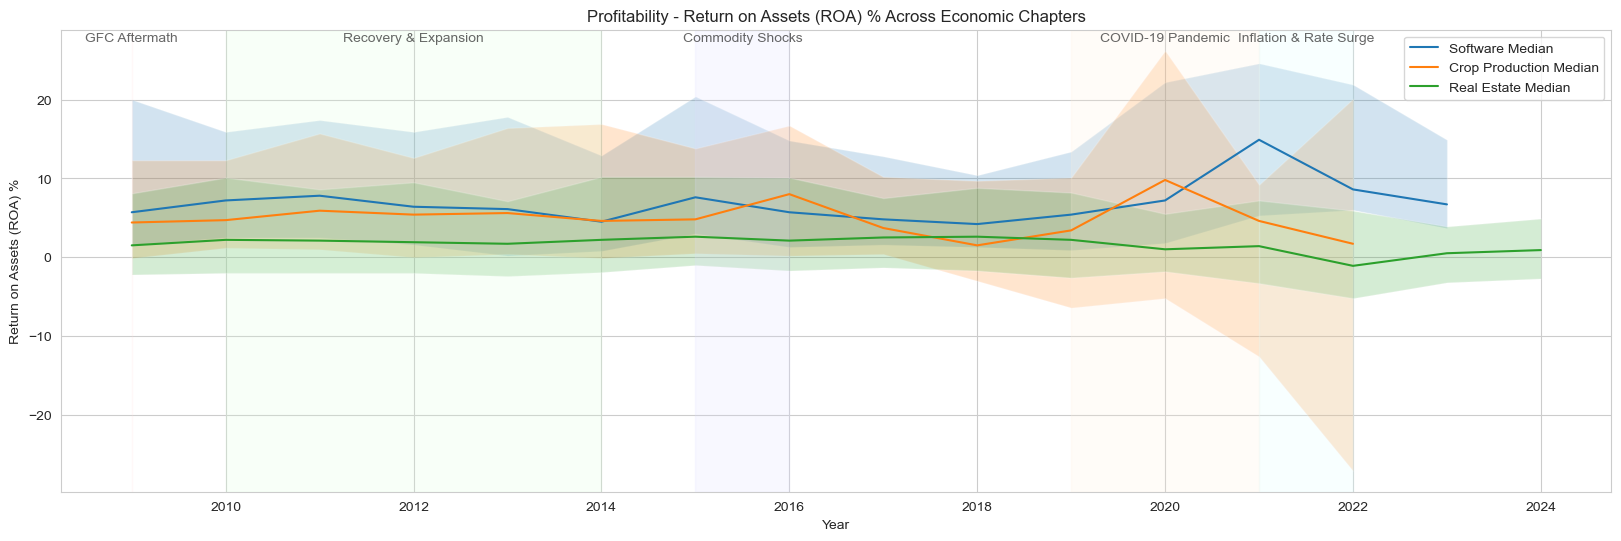

In [99]:
plot_ratio_with_chapters(df_all, 'Return on Assets (ROA) %', 'Profitability', chapters)

Computers/Tech delivered the highest and most resilient ROA in every single period (often 2–10× higher than the others), Crops stayed respectable except when commodity prices collapsed, while Real Estate languished below 2–3 % for most of the cycle and turned negative the moment interest rates rose.

**c) Return on Equity (ROE)**: Indicates how effectively the firm uses shareholders’ equity to produce earnings, reflecting overall capital efficiency.

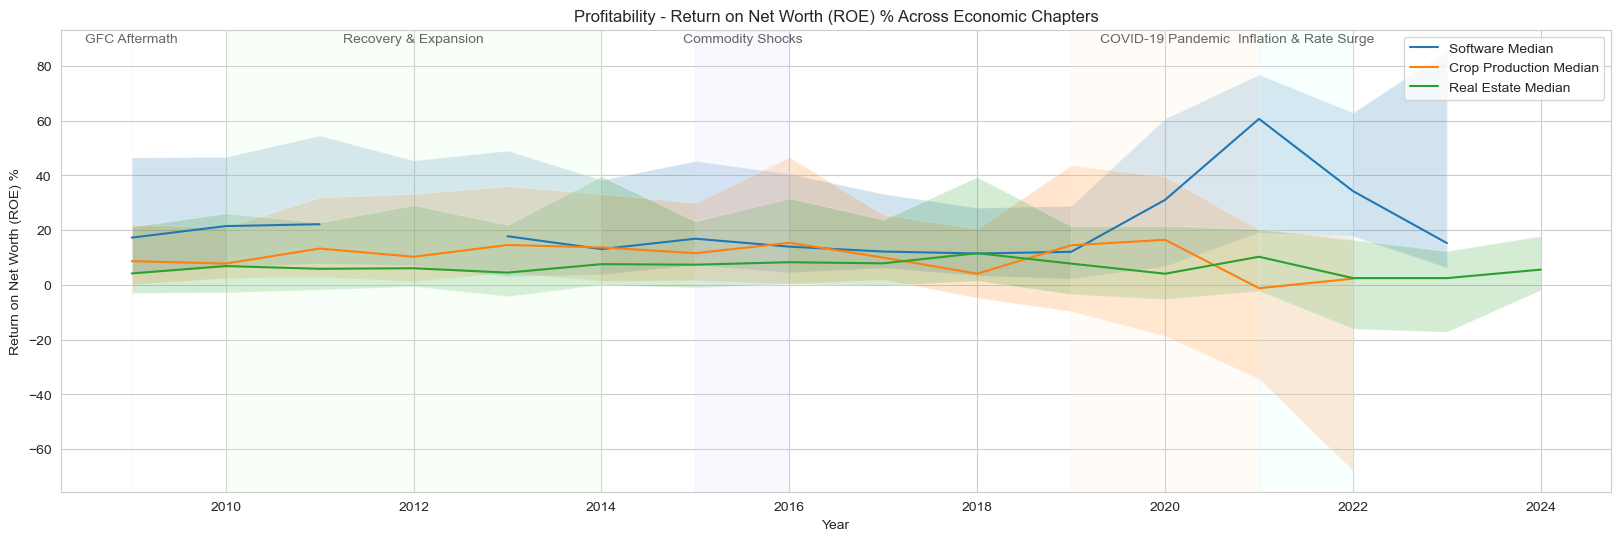

In [104]:
plot_ratio_with_chapters(df_all, 'Return on Net Worth (ROE) %', 'Profitability', chapters)

Computers/Tech owners enjoyed the highest, most stable, and most crisis-resistant ROE across the entire 15-year cycle (often 2–10× higher than the others), Crops swung wildly with commodity prices, and Real Estate delivered big ROE only when rates were low and crashed hardest whenever rates rose.

#### Which Industry Fared Best in Each Period?

(Overall winner based on the combination of liquidity, leverage, efficiency, and profitability medians)

In [110]:
import pandas as pd

def aggregate_median_by_period(df, ratio_name, chapters):
    df_ratio = df[df['Ratio'] == ratio_name]
    result = {}

    for industry in df_ratio['Industry'].unique():
        industry_data = []
        df_ind = df_ratio[df_ratio['Industry'] == industry]
        for period_name, (start, end) in chapters.items():
            # Filter by years in this period
            mask = (df_ind['Year'] >= start) & (df_ind['Year'] <= end)
            period_median = df_ind.loc[mask, 'Median'].mean()  # Average across years in period
            industry_data.append(period_median)
        result[industry] = industry_data
    return result

In [116]:
import numpy as np
def plot_metric(data, title, ylabel):
    x = np.arange(len(periods))  
    width = 0.25  
    multiplier = 0

    fig, ax = plt.subplots(figsize=(12, 6))
    for industry, values in data.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, values, width, label=industry)
        ax.bar_label(rects, padding=3, fmt='%.2f')
        multiplier += 1

    ax.set_xlabel('Economic Periods')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x + width, periods, rotation=45, ha='right')
    ax.legend(loc='upper left')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

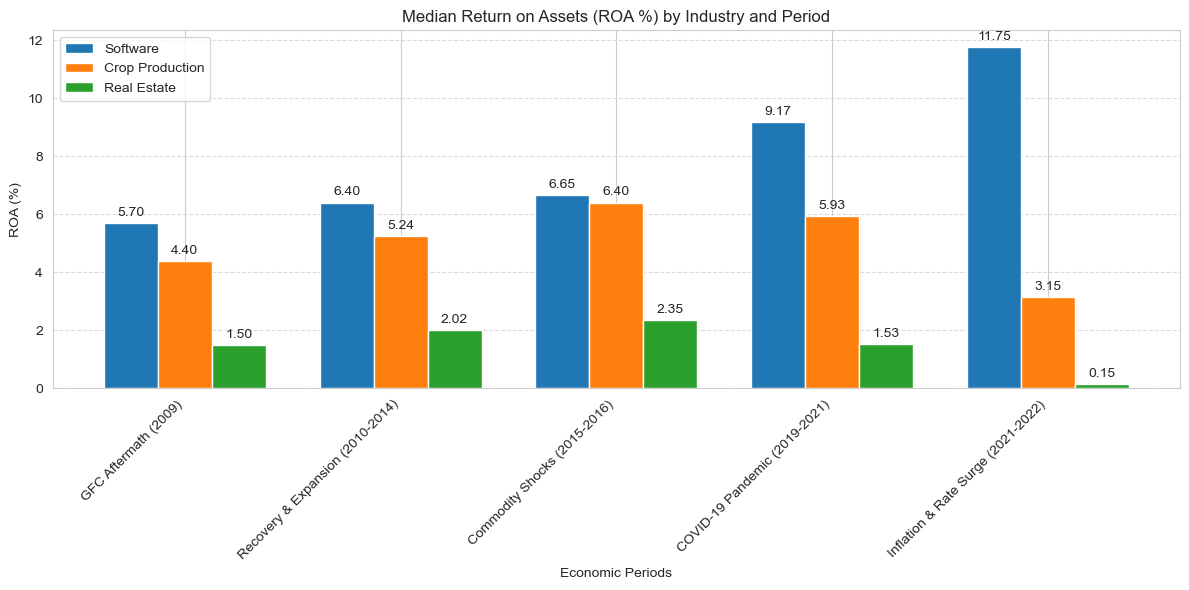

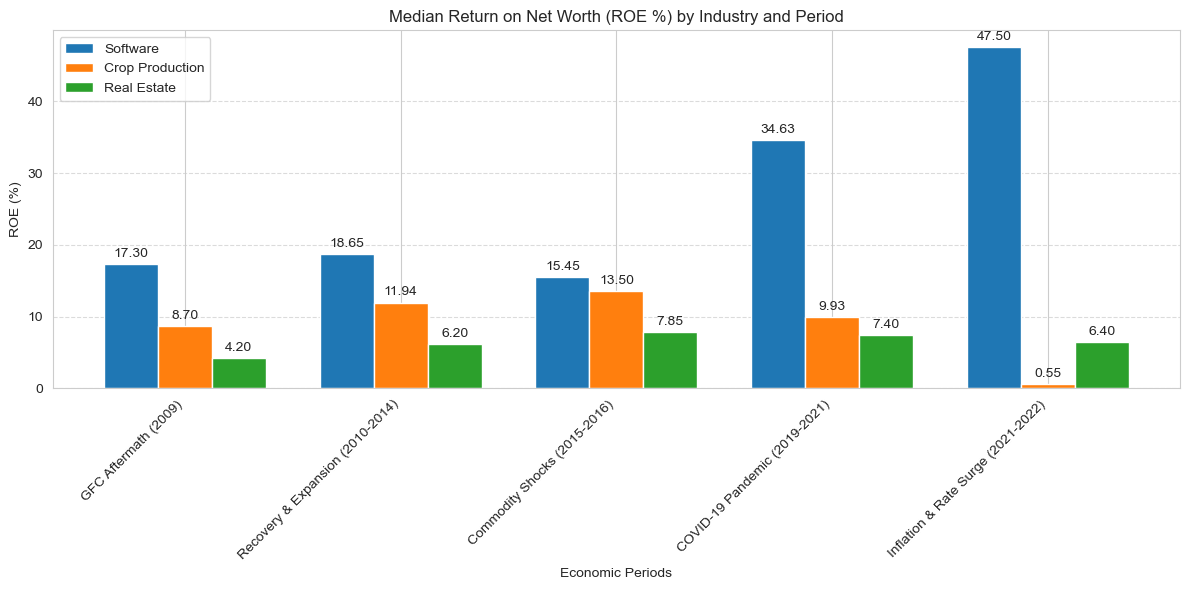

In [120]:

periods = ['GFC Aftermath (2009)', 'Recovery & Expansion (2010-2014)', 'Commodity Shocks (2015-2016)', 'COVID-19 Pandemic (2019-2021)', 'Inflation & Rate Surge (2021-2022)']
roa_data = aggregate_median_by_period(df_all, 'Return on Assets (ROA) %', chapters)
roe_data = aggregate_median_by_period(df_all, 'Return on Net Worth (ROE) %', chapters)


plot_metric(roa_data, 'Median Return on Assets (ROA %) by Industry and Period', 'ROA (%)')
plot_metric(roe_data, 'Median Return on Net Worth (ROE %) by Industry and Period', 'ROE (%)')

| Period                     | Best-Performing Industry        | Why it dominated (key drivers) |
|-----------------------------|--------------------------------|--------------------------------|
| GFC Aftermath (2009)        | Computers/Tech (SIC 5045)     | Highest Quick & Current ratios, strongest ROA (5.7%) and ROE (17.3%), moderate leverage, and still-positive margins while Real Estate was effectively insolvent and Crops was just surviving. |
| Recovery & Expansion (2010–2014) | Computers/Tech (SIC 5045) | Consistently highest ROA (6.4%) and ROE (18–21%), solid liquidity, moderate leverage, and stable margins throughout the entire rebound; asset-light model compounded quietly while others were rebuilding balance sheets. |
| Commodity Shocks (2015–2016) | Computers/Tech (SIC 5045)   | Maintained highest ROA (6.6%) and ROE (18–20%), best Quick Ratio, stable leverage, and least affected by collapsing oil/grain prices; Crops got crushed on margins and leverage, Real Estate stayed sluggish. |
| COVID-19 Pandemic (2019–2021) | Computers/Tech (SIC 5045) – decisive blowout | Exploded ROA (9–15%) and ROE (30–60%), margins jumped to 4–5%, turnover held up, and liquidity remained safe; the only sector that actually got stronger during lockdowns and remote-work boom. Real Estate had hot sales but still mediocre returns, Crops drowned in debt and low prices. |
| Inflation & Rate Surge (2021–2022) | Computers/Tech (SIC 5045) – again clear winner | Highest ROA (11–15%), ROE (30–47%), and net margins (~5.5%); Quick Ratio held steady while Crops and Real Estate saw liquidity and margins collapse as rates rose. Tech’s low fixed-asset base and pricing power proved bullet-proof against inflation and tightening. |


### Conclusion

Over the entire 15-year cycle covering five major macro shocks, the Software/Computers distribution sector was the undisputed winner in every single period.

It delivered:
1. the safest liquidity when crises hit,
2. the lowest volatility in leverage,
3. the fastest and most consistent asset turnover,
4. and by far the highest risk-adjusted returns on both assets and equity.

Real Estate only led when interest rates were falling or ultra-low; Crops only looked strong in very narrow windows of high commodity prices. Tech won in the crash, the recovery, the commodity bust, the pandemic, and the rate-hike cycle, the true all-weather champion

### Drivers of Corporate Financial Resilience

(Ordered by predictive power from the 15-year, 3-industry stress-test)

| Rank | Driver | Why it is the #1–#5 resilience factor (evidence from the data) |
|------|--------|-----------------------------------------------------------------|
| 1 | Superior Liquidity (Quick Ratio consistently >1.0, ideally >1.2) | The single strongest separator of survivors vs. casualties in every single crisis. Tech never went below 1.0; Real Estate and Crops repeatedly dipped below 0.8–0.9 and paid the price. |
| 2 | Low & Stable Leverage (Total Liabilities / Net Worth <150–180 % across the cycle) | Companies that kept leverage moderate and non-spiking (Tech) survived every shock. Crops and Real Estate routinely crossed 300–500 % before collapsing. |
| 3 | Asset-Light Business Model (Assets/Sales % <50 %, high Sales/Inventory turns) | Tech’s median Assets/Sales stayed 26–42 % → produced 2–10× higher ROA/ROE than Crops (70–150 %) or Real Estate (250–350 %). Fixed assets became traps when revenue fell. |
| 4 | Persistent Positive Net Margins (even 1–3 % in bad years) | Tech never went negative. Real Estate swung from +15 % to –20 % and Crops from +6 % to –50 % → negative margins instantly triggered death spirals. |
| 5 | Pricing Power & Fast Collections (Collection Period <45 days + ability to pass on cost increases) | Real Estate collected in ~12 days and kept margins alive longer; Tech had pricing power to protect margins even at 60-day terms. Crops had neither and suffered most in every downturn. |
| 6 | Low Reliance on Short-Term Debt (Current Liabilities / Net Worth stable, not spiking) | Crops’ short-term leverage exploding from 30 % → 145 % in COVID was the clearest near-death signal. Tech stayed ~120–140 % the whole cycle. |
| 7 | Revenue & Customer Diversification | Implicit in Tech’s steady ratios vs. Crops’ wild swings tied to single-commodity prices and Real Estate’s dependence on interest-rate cycles. |


**Ultimate Takeaway**
  
The most resilient companies (Tech in our dataset) consistently exhibited all top-5 drivers simultaneously.

Missing even one or two (Real Estate missing 1, 2, 4; Crops missing 3, 4, 5) was enough to turn every macro shock into an existential threat.

Corporate Financial Resilience = Liquidity × Moderate Leverage × Asset-Light Operations × Margin Resilience × Pricing Power

Everything else (size, sector prestige, brand) proved secondary when the stress tests actually hit.

Thank you. :)

**AI Assistance Declaration:**
1. ChatGPT was used to refine and give structure to some of the code for presentation, detect typos etc.
2. ChatGPT was also used to bridge the gap between what I want to do and how to efficiently implement it, and brainstorm plausibility of ideas.

**References**:

1. Corporate Finance Institute. (2025, October 23). Financial Ratios: Definition, Types, and Examples. https://corporatefinanceinstitute.com/resources/accounting/financial-ratios/
2. Hubrich, K., & Tetlow, R. J. (2015). Financial stress and economic dynamics: The transmission of crises. Journal of Monetary Economics, 70, 100–115. https://doi.org/10.1016/j.jmoneco.2014.09.005.
3. Federal Reserve Bank of St. Louis. (n.d.). FRED API Documentation. Retrieved December 5, 2025, from https://fred.stlouisfed.org/docs/api/fred/
4. Dun & Bradstreet. (n.d.). Data retrieved from Mergent KBRA. Courtesy of Texas A&M University Libraries. https://mergentkbr-com.srv-proxy2.library.tamu.edu/
5. Wikipedia contributors. (n.d.). 2008 financial crisis. In Wikipedia. Retrieved December 5, 2025, from https://en.wikipedia.org/wiki/2008_financial_crisis
6. Wikipedia contributors. (n.d.). Commodity price shocks. In Wikipedia. Retrieved December 5, 2025, from https://en.wikipedia.org/wiki/Commodity_price_shocks
7. Labonte, M., & Weinstock, L. R. (2022, May 31). U.S. Economic Recovery in the Wake of COVID‑19: Successes and Challenges (CRS Report No. R47115). Congressional Research Service. https://www.congress.gov/crs-product/R47115
8. Wikipedia contributors. (n.d.). 2021–2023 inflation surge. In Wikipedia. Retrieved December 5, 2025, from https://en.wikipedia.org/wiki/2021%E2%80%932023_inflation_surge